# Mapa das eleições de Dep. Estadual de 2018 por Zona Eleitoral no estado de SP

In [ ]:
'''
Fontes:
IBGE - shapefiles
https://mapas.ibge.gov.br/bases-e-referenciais/bases-cartograficas/malhas-digitais.html
ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2015/Brasil/BR/br_municipios.zip

TSE - resultado eleição
http://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais/
http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip
http://www.tse.jus.br/eleitor/cartorios-e-zonas-eleitorais/pesquisa-a-zonas-eleitorais

mapaslivres - correspondencia entre TSE e IBGE
https://github.com/mapaslivres/zonas-eleitorais

Estadão Dados - zonas eleitorais
https://drive.google.com/drive/u/1/folders/1qwTlkNnt5SEnzirhrXbSXGST6vNvUAVM

Dados Abertos SP - shapefile
http://dados.prefeitura.sp.gov.br/pt_PT/dataset/distritos/resource/9e75c2f7-5729-4398-8a83-b4640f072b5d
'''

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Read input file in order to collect voting database in chunks due file size
df_chunk = pd.read_csv('./votos/votacao_candidato_munzona_2018_SP.csv', sep=';', encoding='latin1', chunksize=10000)

In [3]:
cols = ['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'DS_CARGO',
        'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 
        'QT_VOTOS_NOMINAIS']

DS_CARGO = 'Deputado Estadual'

In [4]:
chunk_list = []

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    chunk_filter = chunk[chunk['DS_CARGO'] == DS_CARGO]
    #chunk_filter = chunk_filter[chunk_filter['NR_CANDIDATO'] == NR_CANDIDATO]
    chunk_filter = chunk_filter[cols]
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
df_concat = pd.concat(chunk_list)

In [121]:
# Filtering candidate number
NR_CANDIDATO = 17317
df_candidato = df_concat[df_concat['NR_CANDIDATO'] == NR_CANDIDATO]
df_candidato.sort_values('QT_VOTOS_NOMINAIS', ascending=False)

,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,DS_CARGO,NR_CANDIDATO,NM_URNA_CANDIDATO,NR_PARTIDO,SG_PARTIDO,QT_VOTOS_NOMINAIS
1249058,71072,SÃO PAULO,258,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,28020
1722298,71072,SÃO PAULO,253,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,24010
2845756,71072,SÃO PAULO,6,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,20442
2636426,71072,SÃO PAULO,4,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,20264
1545440,62910,CAMPINAS,275,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,19029
...,...,...,...,...,...,...,...,...,...
14738,62421,RIBEIRÃO DOS ÍNDIOS,117,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,18
857340,62120,PRACINHA,69,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,15
925077,61786,BOM SUCESSO DE ITARARÉ,57,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,15
362326,61948,ITAPIRAPUÃ PAULISTA,10,Deputado Estadual,17317,JANAINA PASCHOAL,17,PSL,14


In [122]:
df_zona = df_candidato.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()
df_zona.shape

(393, 4)

In [123]:
# Total candidate votes
df_zona['QT_VOTOS_NOMINAIS'].sum()

2060786

In [124]:
# Importing shapefile
df_mapa = gpd.read_file('./geo/SP_ZONAS_janeiro_2018/ZONAS_FINAL.shp')
#df_mapa.head()

In [125]:
df_mapa_novo = df_mapa.join(df_zona)
df_mapa_novo.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

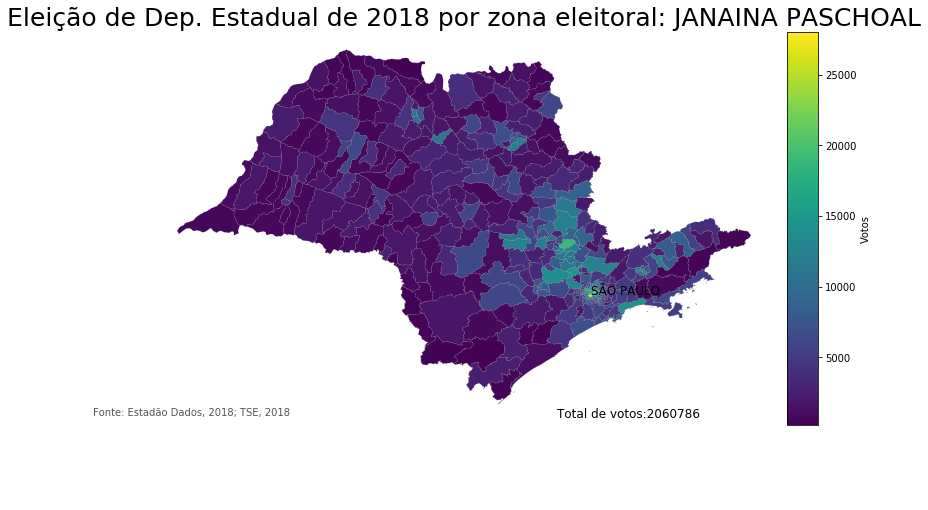

In [126]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(12,12))

df_mapa_novo["center"] = df_mapa_novo["geometry"].centroid
df_points = df_mapa_novo.copy()
df_points.set_geometry("center", inplace = True)

for x, y, label in zip(df_points[:1].geometry.x, df_points[:1].geometry.y, df_points[:1]['FIRST_sede']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = df_mapa_novo.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': "Votos", 'orientation': "vertical"}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por zona eleitoral: '+ df_mapa_novo['NM_URNA_CANDIDATO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Total de votos:' + str(df_mapa_novo['QT_VOTOS_NOMINAIS'].sum()), xy=(0.6,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
plt.show()
#fig.savefig('sp-estado.png')

In [127]:
ranking = df_mapa_novo[['FIRST_NOME','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'index':'Zona'}, inplace = True)

In [128]:
ranking.head()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
0,239,SÃO PAULO - INDIANÓPOLIS,28020,1.359675
1,234,SÃO PAULO - TATUAPÉ,24010,1.165089
2,5,SÃO PAULO - VILA MARIANA,20442,0.991952
3,3,SÃO PAULO - MOÓCA,20264,0.983314
4,255,CAMPINAS,19029,0.923386


In [129]:
ranking.tail()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
388,216,ESTRELA D'OESTE,409,0.019847
389,154,PAULO DE FARIA,388,0.018828
390,202,MIRACATU,367,0.017809
391,9,APIAÍ,343,0.016644
392,140,ELDORADO,216,0.010481


In [79]:
# Definir partido para analisar
NR_PARTIDO = 17
df_part = df_concat[df_concat['NR_PARTIDO'] == NR_PARTIDO]
df_part_zona = df_part.groupby(['NR_ZONA', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()

In [80]:
df_mapa_part = df_mapa.join(df_part_zona)
df_mapa_part.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

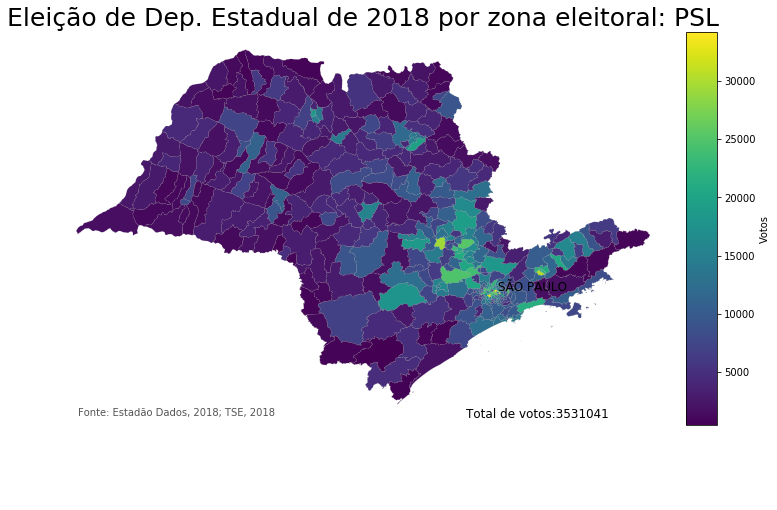

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(12,12))

df_mapa_part["center"] = df_mapa_part["geometry"].centroid
df_points = df_mapa_part.copy()
df_points.set_geometry("center", inplace = True)

for x, y, label in zip(df_points[:1].geometry.x, df_points[:1].geometry.y, df_points[:1]['FIRST_sede']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = df_mapa_part.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': "Votos", 'orientation': "vertical"}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por zona eleitoral: '+ df_mapa_part['SG_PARTIDO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Total de votos:' + str(df_mapa_part['QT_VOTOS_NOMINAIS'].sum()), xy=(0.6,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.2),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')
plt.show()
#fig.savefig('sp-estado-'+ df_part['SG_PARTIDO'].iloc[0] +'.png')

In [115]:
ranking = df_mapa_part[['FIRST_NOME','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'index':'Zona'}, inplace = True)

In [116]:
ranking.head()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
0,234,SÃO PAULO - TATUAPÉ,34187,0.968185
1,239,SÃO PAULO - INDIANÓPOLIS,33109,0.937655
2,378,SÃO JOSÉ DOS CAMPOS,30304,0.858217
3,174,SANTA BÁRBARA D'OESTE,29432,0.833522
4,3,SÃO PAULO - MOÓCA,27242,0.771501


In [117]:
ranking.tail()

,Zona,FIRST_NOME,QT_VOTOS_NOMINAIS,%
388,216,ESTRELA D'OESTE,785,0.022231
389,154,PAULO DE FARIA,746,0.021127
390,289,OURINHOS,739,0.020929
391,35,CANANÉIA,711,0.020136
392,140,ELDORADO,456,0.012914
